### Read xlsx data and import libraries

In [1]:
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import graphviz

datafile = pd.read_excel('atus/ehresp_2014.xlsx')
#column_names = ['eeincome1', 'erhhch', 'erincome', 'erspemch', 'ertpreat', 'ertseat', 'eudietsoda', 'eudrink', 'eueat', 'euexercise', 'euexfreq', 'eufastfd', 'eufastfdfrq', 'euffyday', 'eufdsit', 'eufinlwgt', 'eusnap', 'eugroshp', 'euinclvl', 'euincome2', 'eumeat', 'eumilk', 'euprpmel', 'eusoda', 'eustores', 'eustreason', 'eutherm', 'euwic', 'exincome1', 'eugenhth', 'erbmi']
#target_column_name = 'erbmi'
#dataset = load[column_names]
#print(dataset.shape)
#print(dataset[0:3])
#dataset.dtypes

### Replace all nonvalid value codes with 0 and remove all rows where the BMI or GenHealth data is missing.

In [2]:
# works on datafile, result is dataset

dataset = datafile.applymap(lambda x: max(x,0))
empty_rows = list()
for i in range(dataset.shape[0]):
    if dataset.iloc[i]['erbmi'] == 0 or dataset.iloc[i]['eugenhth']==0:
        empty_rows.append(i)
dataset.drop(index=empty_rows, inplace=True)
dataset.dropna(axis=0,subset=['erbmi','eugenhth'],inplace=True)
dataset = dataset.reset_index(drop=True)
#df.shape
#df.loc[:4]

In [3]:
#dataset['erbmi']

### Create column 'bmi' by categorizing data in 'erbmi'

In [4]:
def bmi_intlabel(x):
    if x <= 0:
        return 0
    elif x < 18.5:
        return 1
    elif x < 25:
        return 2
    elif x < 30:
        return 3
    return 4

bmi_labels=["Unreported","Underweight","Healthy","Overweight","Obese"]
hthlabels = ["Unreported", "Excellent", "Very Good", "Good", "Fair","Poor"]

bmi_data = list()
for i in range(dataset.shape[0]):
    bmi_data.append(int(bmi_intlabel(dataset.iloc[i]['erbmi'])))

df_temp = pd.DataFrame({"bmi": pd.Series(bmi_data)})
#df_temp.astype('int32',copy=True)
dataset = pd.concat([dataset,df_temp],axis=1,sort=False)

In [5]:
#dataset[10600:]

### Create Column 'income' from column 'erincome'
(erincome combines data from two different questions, but it's values of 2,3, and 4 are hard to differentiate, so combine into one value of 2)

In [6]:
income_data = list()
for i in range(dataset.shape[0]):
    income = int(dataset.iloc[i]['erincome'])
    if income == 3 or income == 4:
        income = 2
    income_data.append(income)
df_temp = pd.DataFrame({"income": income_data})
dataset = pd.concat([dataset,df_temp],axis=1,sort=False)

In [7]:
#data.dtypes

In [8]:
#dataset.iloc[-4:]

### Define a function to One Hot Encode selected categorical columns from a dataframe

In [9]:
def onehot_categorical_columns(file, columns):
    # Adapted from prepare_categorical_columns in Eric Heilander's prepareData notebook   
    # Extract columns from file; convert to array
    dataset = file[columns]
    
    # Apply LabelEncoder to multiple columns: https://stackoverflow.com/a/31939145
    dataset = pd.DataFrame(dataset).apply(LabelEncoder().fit_transform)

    # OHE for multiple columns using pd.get_dummies: https://stackoverflow.com/a/44601764
    # Another get_dummies example: http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
    # OHE vs. get_dummies: https://medium.com/@guaisang/handling-categorical-features-get-dummies-onehotencoder-and-multicollinearity-f9d473a40417
    dataset_df = pd.DataFrame(dataset, columns=columns)
    # Keep only the columns we want, and drop the extraneous dummy column
    dataset_dummies = pd.get_dummies(dataset_df,
                                     columns=columns,
                                     drop_first=True)
    dataset = dataset_dummies
    return dataset

### Onehot categorical columns  and remerge with numerical columns.

In [10]:
numerical_columns = ['ertpreat', # total amount of time spent in primary eating and drinking \
                     'ertseat',  # time spent in secondary eating \
                     'euexfreq',  # reported number of times exercised in last week \
                     'eufastfdfrq']  # reported number of times buying fast food or prepared food 
                     #'euhgt', \ # reported height. Already a factor in BMI, so no gain from including
                     #'euwgt'] # reported weight. Already a factor in BMI, so not gain from including

categorical_columns = [#'eeincome1',  # is income greater than, less than, or equal to 185% of poverty threshold \
                       'erhhch',  # Change in Household composition \
                       #'erincome',  # replaced with income column \
                       'erspemch',  # change in spouse's employment
                       #'ethgt',  # topcode flag, is metadata
                       #'etwgt',  # topcode flag, is metadata
                       'eudietsoda',  # Was the softdrink diet, regular, or both
                       'eudrink',  # Did you drink non-water beveridges yesterday
                       'eueat',  # Did you eat or drink while doing something else ?
                       'euexercise', # Did you exercise in the last week ?
                       'eufastfd',  # Did you eat any fast food last week 
                       'euffyday',  # Did you eat fast food yesterday ?
                       'eufdsit',  # Did you get enough to eat yesterday ?
                       'eusnap',  # Did anyone in your household get food stamps ?
                       #'eugenhth',  # Is a target
                       'eugroshp',  # Are you the primary grocery shopper ?
                       #'euinclvl',  # Which year's primary threshold was used
                       #'euincome2',  # incomed compared to 130% of poverty
                       'eumeat',  # Did you eat meat last week ?
                       'eumilk',  # Did you drink or serve raw milk ?
                       'euprpmel',  # Are you the main cook in your household ?
                       'eusoda',  # Did you drink soft drinks ?
                       'eustores',  # At what kind of store do you buy groceries ?
                       'eustreason',  # Why ?
                       'eutherm',  # Do you use a meat thermometer ?
                       'euwic',  # Did you get WIC benefits ?
                       'bmi', # categorized bmi
                       'income']

one_df = onehot_categorical_columns(dataset,categorical_columns)
numerical_df = dataset.loc[:,numerical_columns]
merged_df = pd.concat([numerical_df, one_df],axis=1,sort=False)

In [11]:
merged_df[:4]

,ertpreat,ertseat,euexfreq,eufastfdfrq,erhhch_1,erhhch_2,erspemch_1,erspemch_2,erspemch_3,erspemch_4,...,eutherm_1,eutherm_2,euwic_1,euwic_2,bmi_1,bmi_2,bmi_3,income_1,income_2,income_3
0,30,2,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0
1,45,14,0,1,0,1,0,0,0,0,...,0,1,0,1,1,0,0,1,0,0
2,60,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
3,65,0,5,0,0,1,0,0,0,0,...,0,1,1,0,0,0,1,0,0,1


## Train a Decision Tree Classifier using 'genhth' as the target

In [12]:
from sklearn.model_selection import train_test_split
hth_Xtrain, hth_Xtest, hth_ytrain, hth_ytest = train_test_split(merged_df, dataset['eugenhth'], test_size = 0.1)
#print(X_cols)
#X_cols.remove('eugenhth')
#X_cols.remove('genhth')
#X_cols.remove('bmi')
#X_cols.remove('eufinlwgt')
#X_cols.remove('erbmi')
#X['erincome'] = X['erincome'].astype('category')
#X = data.loc[:,X_cols]
#X=X.dropna(how='any')
#X
#y = data['genhth']
#y
#hth_classifier = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)
hth_classifier = tree.DecisionTreeClassifier(max_depth = 5)
hth_classifier.fit(hth_Xtrain, hth_ytrain)
print()

In [13]:
print(metrics.confusion_matrix(hth_ytest, hth_classifier.predict(hth_Xtest)))

[[ 27 111  50   1   1]
 [ 13 264  93   8   1]
 [  2 154 145  16   1]
 [  1  33  68  17   2]
 [  0  11  32   7   3]]


## Display a decision tree showing the major predictors of general health 

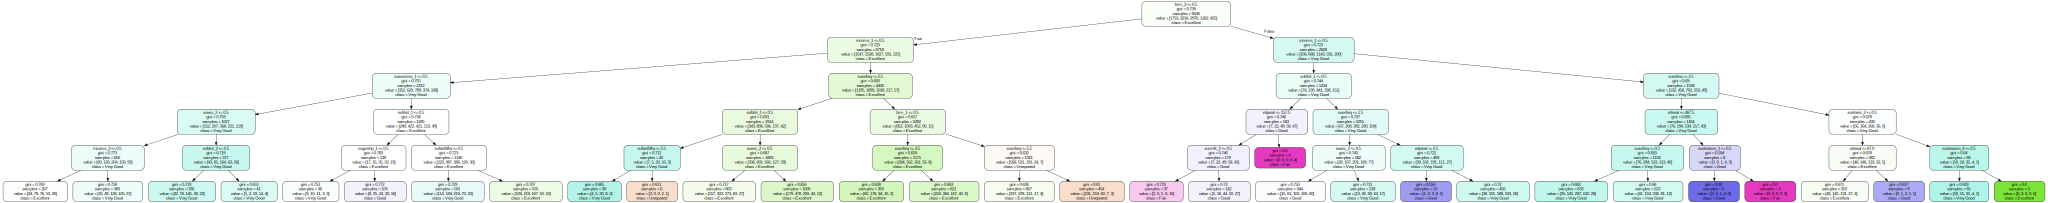

In [14]:
dot_data = tree.export_graphviz(hth_classifier,feature_names=merged_df.columns,class_names=hthlabels[0:],filled=True, rounded=True)
graph = graphviz.Source(dot_data)
#graph.render("BMI")
graph

### Train a classifier to predict BMI

In [15]:
bmi_columns = [x for x in merged_df.columns if 'bmi' not in x]
bmi_X = merged_df.loc[:,bmi_columns]
#bmi_Xtrain, bmi_Xtest, bmi_ytrain, bmi_ytest = train_test_split(merged_df.loc[:,bmi_columns], dataset['bmi'], test_size = 0.1)
bmi_classifier = tree.DecisionTreeClassifier(max_depth=5)
bmi_classifier.fit(bmi_X, dataset['bmi'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
bmi_X.columns

Index(['ertpreat', 'ertseat', 'euexfreq', 'eufastfdfrq', 'erhhch_1',
       'erhhch_2', 'erspemch_1', 'erspemch_2', 'erspemch_3', 'erspemch_4',
       'erspemch_5', 'eudietsoda_1', 'eudietsoda_2', 'eudietsoda_3',
       'eudrink_1', 'eudrink_2', 'eueat_1', 'eueat_2', 'euexercise_1',
       'euexercise_2', 'eufastfd_1', 'eufastfd_2', 'euffyday_1', 'euffyday_2',
       'eufdsit_1', 'eufdsit_2', 'eufdsit_3', 'eusnap_1', 'eusnap_2',
       'eugroshp_1', 'eugroshp_2', 'eugroshp_3', 'eumeat_1', 'eumeat_2',
       'eumilk_1', 'eumilk_2', 'euprpmel_1', 'euprpmel_2', 'euprpmel_3',
       'eusoda_1', 'eusoda_2', 'eustores_1', 'eustores_2', 'eustores_3',
       'eustores_4', 'eustores_5', 'eustreason_1', 'eustreason_2',
       'eustreason_3', 'eustreason_4', 'eustreason_5', 'eustreason_6',
       'eutherm_1', 'eutherm_2', 'euwic_1', 'euwic_2', 'income_1', 'income_2',
       'income_3'],
      dtype='object')

## Display a decision tree showing the major predictors of BMI classes

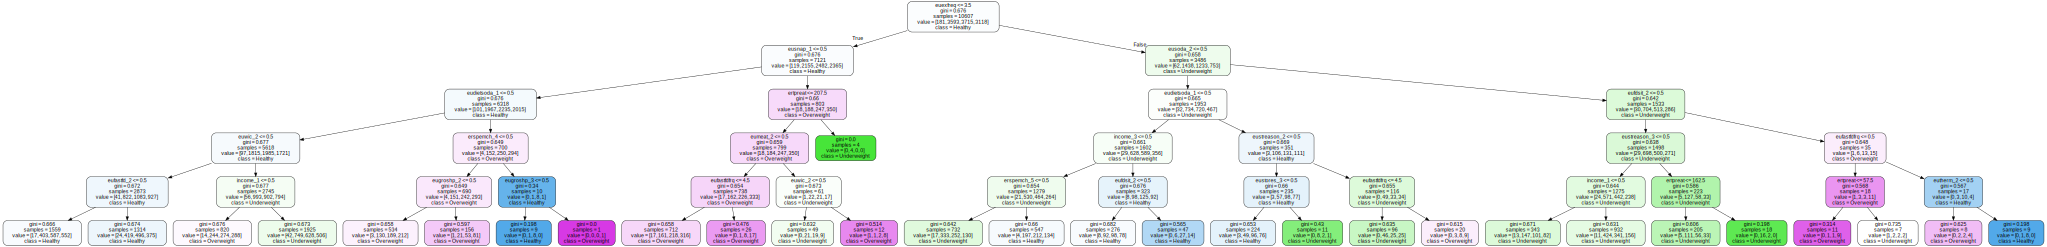

In [17]:
bmi_dot_data = tree.export_graphviz(bmi_classifier,feature_names=bmi_X.columns,class_names=bmi_labels[0:],filled=True, rounded=True)
bmi_graph = graphviz.Source(bmi_dot_data)
#graph.render("BMI")
bmi_graph